In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


in this notebook the following tasks shall be executed 
* sentiment anlaysis using two different approaches 

1. VADER ( Valence Aware Dictionary and sEntiment Reasoner )- Bag of words approach

2. Roberta pretrained model from hugging face 

3. Hugging face pipeline

# step 0 . Reading data and  NLTK basics

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import nltk
import seaborn as sns 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df=pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


# quick eda 

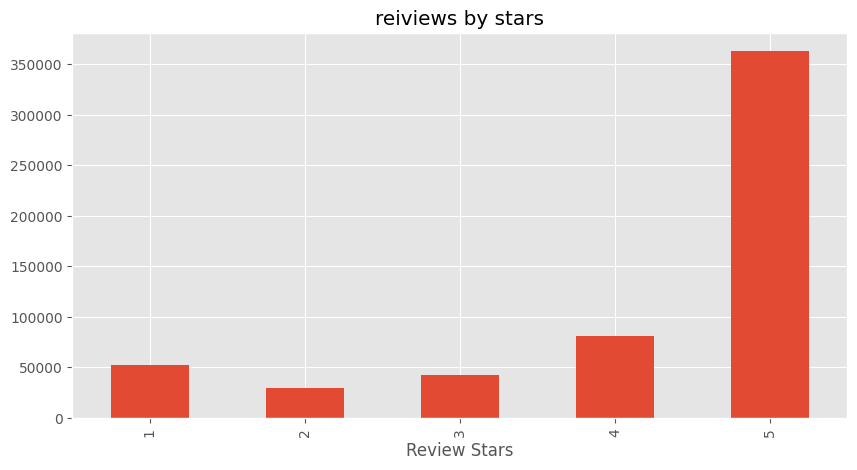

In [4]:
ax=df['Score'].value_counts().sort_index().plot(kind='bar',
                                                title="reiviews by stars",
                                                figsize=(10,5))
ax.set_xlabel('Review Stars')

plt.show()

# NLTK basics 

In [5]:
eg=df['Text'][50]


In [6]:
print(eg)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens = nltk.word_tokenize(eg)

In [8]:
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
tagged=nltk.pos_tag(tokens)

print(tagged)

[('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ'), (',', ','), ('I', 'PRP'), ('do', 'VBP'), ("n't", 'RB'), ('like', 'VB'), ('it', 'PRP'), ('.', '.'), ('Quaker', 'NNP'), ('Oats', 'NNPS'), ('is', 'VBZ'), ('the', 'DT'), ('way', 'NN'), ('to', 'TO'), ('go', 'VB'), ('.', '.')]


In [10]:
entities=nltk.chunk.ne_chunk(tagged)

print(entities) 

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


In [11]:
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


In [12]:
from pprint import pprint

my_dict = {'name': 'John', 'age': 30, 'city': 'New York'}
pprint(my_dict)

{'age': 30, 'city': 'New York', 'name': 'John'}


In [13]:
print(my_dict)

{'name': 'John', 'age': 30, 'city': 'New York'}


step 1 : VADER sentiment scoring :
        
we will use NLTK's `SentimentIntesityAnalyzer`to get the neu/neg/pos sentiment points of a text:
            
* this uses a "bag of words " approach :
                1. stop words are removed like and,the , etc. 
                2. each word is scored and combined to a total score 
                
            

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer

from tqdm.notebook import tqdm 

sia=SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [15]:
sia

In [16]:
sia.polarity_scores("meow !! I am happy to play and so annoyed by your prescence ")

{'neg': 0.156, 'neu': 0.484, 'pos': 0.36, 'compound': 0.5846}

In [17]:
sia.polarity_scores("annoyed unhappy worst")

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.8591}

In [18]:
sia.polarity_scores(eg)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [19]:
eg
df2=df[:500]
df2.shape

(500, 10)

# running the `polarityscores()` on the entire dataset 

In [20]:
res={}

for i , row in tqdm(df2.iterrows(),total=len(df2)):
    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
df_res=pd.DataFrame(res).T
df_res.head()

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.079,0.853,0.068,-0.1027
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [22]:
vaders=df_res

In [23]:
vaders=vaders.reset_index().rename(columns={'index':'Id'})

In [24]:
vaders.head()
vaders.shape

(500, 5)

In [25]:
vaders=vaders.merge(df2,how="left")
# vaders=vaders.drop('index',axis=1)
# vaders.set_index(df2("Id"))

vaders.head()


,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [26]:
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.554,0.446,0.9725,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,0.059,0.791,0.150,0.8215,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,0.025,0.762,0.212,0.9848,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,0.041,0.904,0.055,0.1280,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


Text(0.5, 1.0, 'star review amazon ')

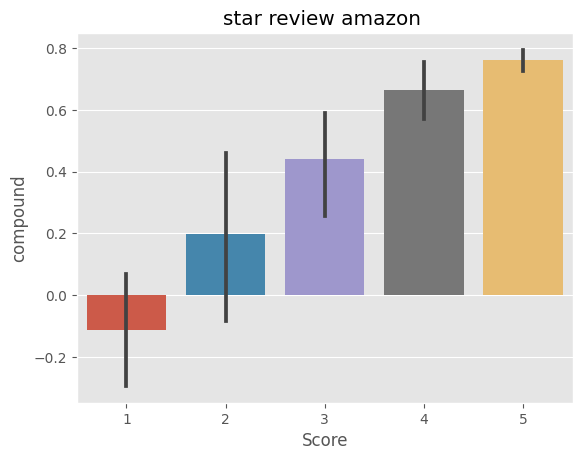

In [27]:
ax=sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title("star review amazon ")

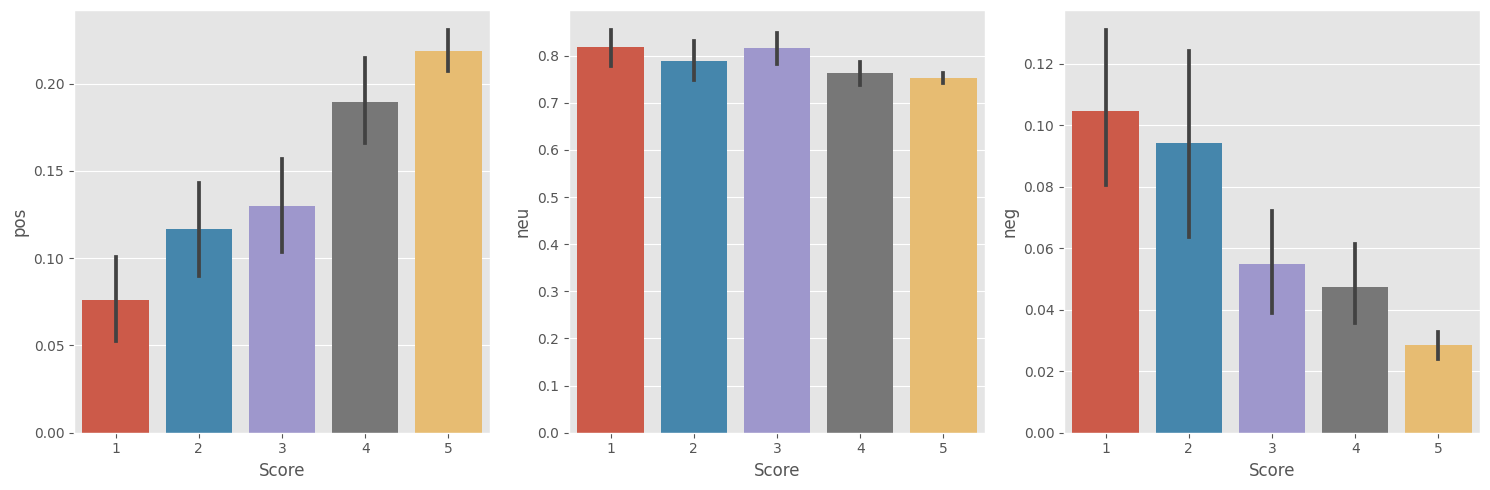

In [28]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders,x='Score',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=axs[2])
plt.tight_layout()
plt.show()


# using Roberta pretrained model :

* trained on a very large data 

* even considers the context related to the words 



In [29]:
import transformers

In [30]:


from transformers import AutoTokenizer

from transformers import AutoModelForSequenceClassification

In [31]:
from scipy.special import softmax

In [32]:


task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer=AutoTokenizer.from_pretrained(MODEL)

model=AutoModelForSequenceClassification.from_pretrained(MODEL)

# VADER results on eg 

In [33]:
print(eg)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [34]:
sia.polarity_scores(eg)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

# running for Roberta model 

In [35]:
encoded_text=tokenizer(eg,return_tensors='pt')
output=model(**encoded_text)
scores=output[0][0].detach().numpy()

scores=softmax(scores)

scores_dict={
    'roberta_neg': scores[0],
    'roberta_neu':scores[1],
    'roberta_pos': scores[2]
    
}

print(scores_dict)

{'roberta_neg': 0.9763551, 'roberta_neu': 0.020687481, 'roberta_pos': 0.0029573715}


In [36]:
def psr(eg):
    encoded_text=tokenizer(eg,return_tensors='pt')
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()

    scores=softmax(scores)

    scores_dict={
        'roberta_neg': scores[0],
    'roberta_neu':scores[1],
    'roberta_pos': scores[2]
    
    }

    return scores_dict

In [38]:

res={}

for i , row in tqdm(df2.iterrows(),total=len(df2)):
    try:
        text=row['Text']
        myid=row['Id']
        vader_res=sia.polarity_scores(text)
        roberta_res=psr(text)
        vader_res_rename={}
        for key,value in vader_res.items():
            vader_res_rename[f"vader_{key}"]=value
        roberta_res=psr(text)
        both={**vader_res_rename,**roberta_res}
        res[myid]=both
        
    except RuntimeError:
        print(f"broke for id {myid}")
        
    
    


  0%|          | 0/500 [00:00<?, ?it/s]

broke for id 83
broke for id 187


In [39]:
res_df=pd.DataFrame(res).T
res_df=res_df.reset_index().rename(columns={'index':'Id'})
res_df=res_df.merge(df,how='left')


# comparing the scores b/w the 2 models 

In [40]:
res_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


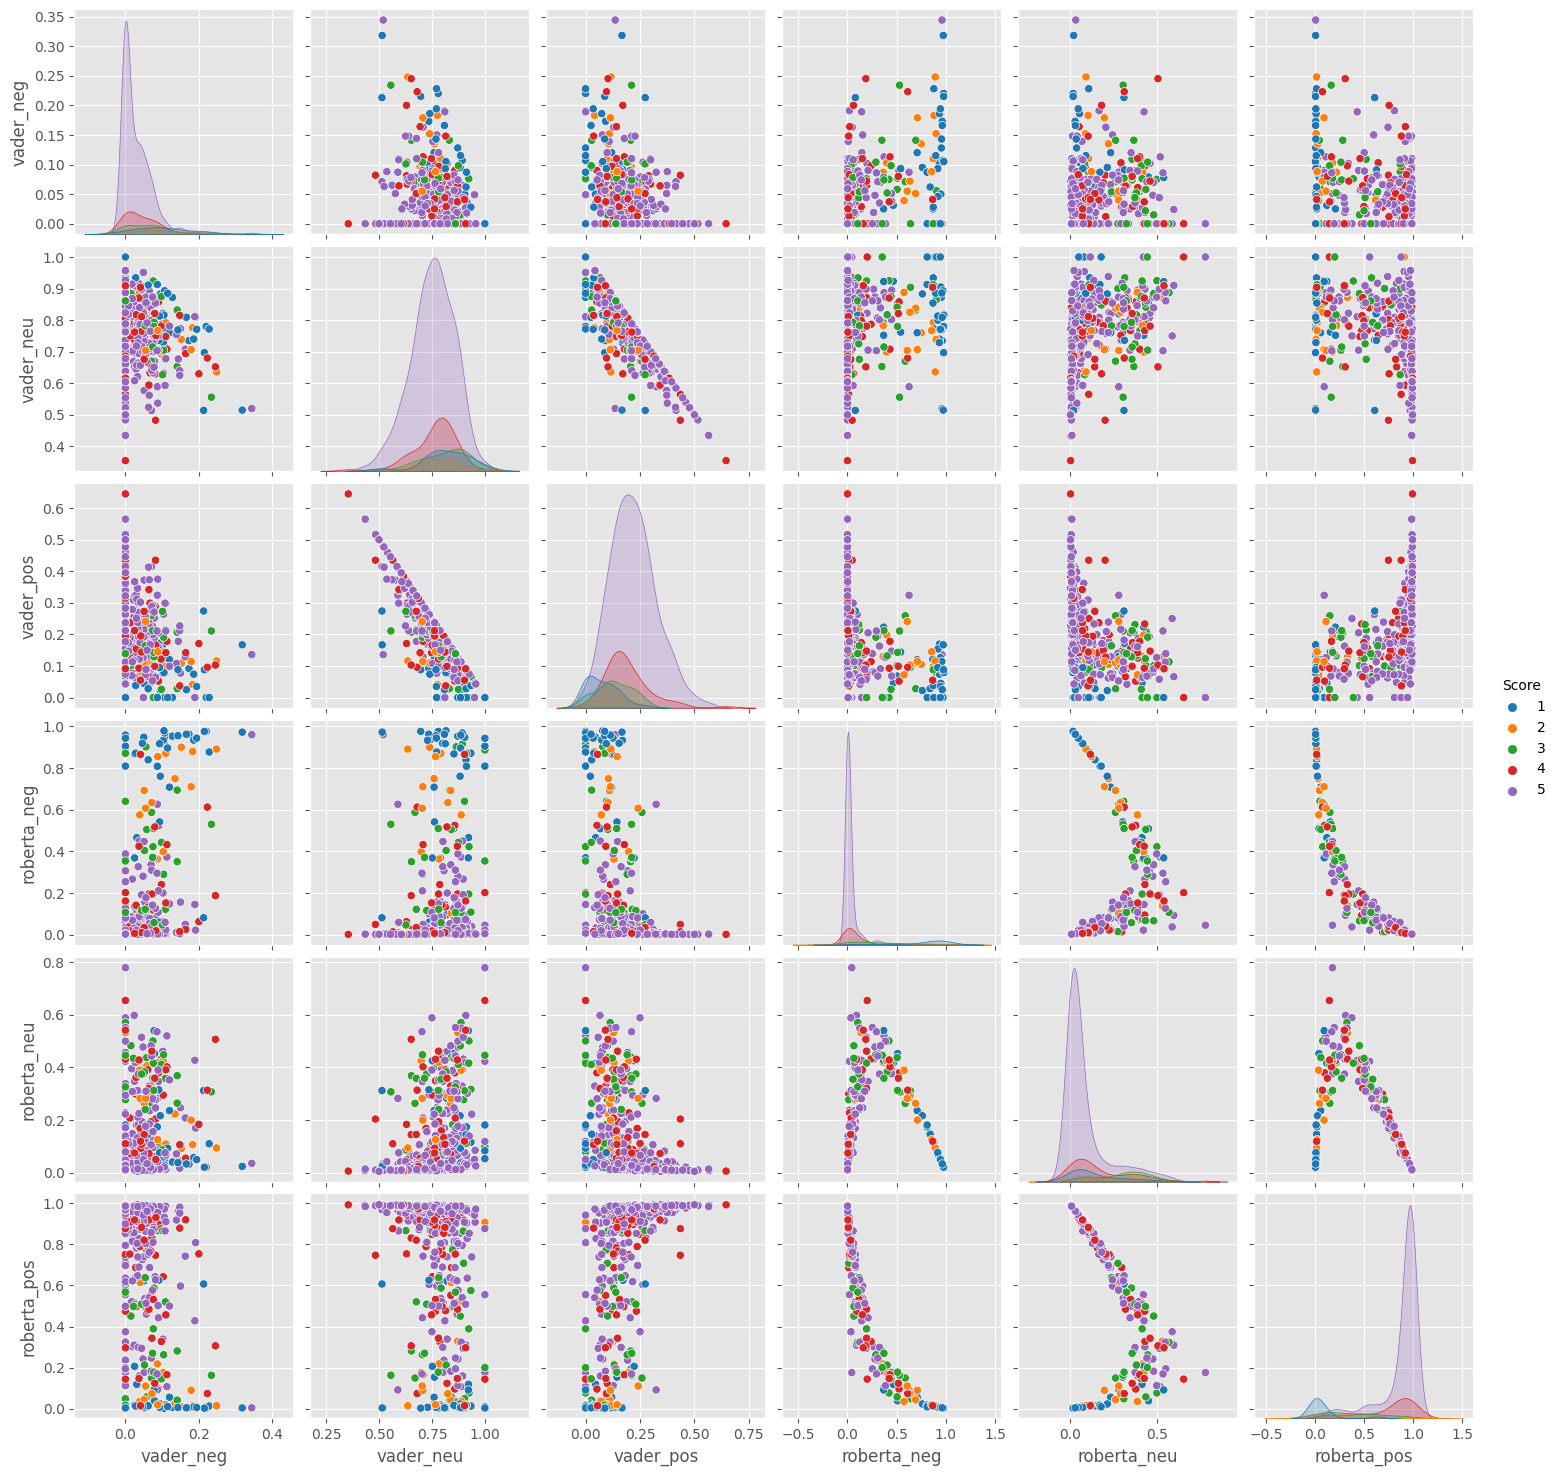

In [41]:
sns.pairplot(data=res_df,
            vars=['vader_neg', 'vader_neu', 'vader_pos', 
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')

plt.show()
